In [1]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


data = pd.read_csv('./data/dan_table.csv')

# TrialStart = 0, 1. much more TrialStart == 0 than ==1 
# First lick: Reward Enter
# Next lick: Reward Exit (after they havne't licked for a while) -- not super reliable 

In [2]:
def inv_logit(arr):
    '''Elementwise inverse logit (logistic) function.'''
    return 1 / (1 + np.exp(-arr))

def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal. 
    For details, see Bowling et al. (2009). "A logistic approximation 
    to the cumulative normal distribution."'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

In [3]:
data = data[(data['RecordLoc'] == 1) ]

# Somehow the length of data is different for different RecordLoc... I'm going to use DMS since I'll want to 
# model the neural data from that area later 
#         1 = VTA/SNc -> Dorsomedial Striatum
#         2 = VTA/SNc -> Nucleus Accumbens
#         3 = VTA/ SNc -> Dorsolateral Striatum (forgot i had these)
#         4 = VTA/ SNc -> Dorsomedial Striatum Cell Bodies
#         5 = GFP controls (DMS and NAc together)

In [4]:
# pull out trial by trial info 

data_t = []

for mouse_id in np.unique(data['MouseID']):
    data_small = data[data['MouseID'] == mouse_id]

    trial_starts = np.where(data_small['TrialStart'] == 1)[0]
    num_trials = len(trial_starts)

    for t_i, t in enumerate(trial_starts):

        if t_i == (num_trials - 1):
            trial_end = len(data_small)
        else:
            trial_end = trial_starts[t_i + 1]

        trial_df = data_small[t:trial_end];

#         lever_press = np.where(trial_df['LeverPresentation'] == 1)[0][0]
        if sum(trial_df.IpsLeverPress.values) >  sum(trial_df.ConLeverPress.values):
            action = 'Ips'
        else:
            action = 'Con'

        if sum(trial_df.CSplus.values) >  sum(trial_df.CSneg.values):
            reward = 1
        else:
            reward = 0

        data_t.append([ mouse_id, t_i, action, reward, t, trial_end]) #  lever_press])


    
    
        

In [5]:
df_trials = pd.DataFrame(data_t, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'TrialStart', 'TrialEnd')) # , 'LeverPress'))
df_trials['TrialLen'] = df_trials['TrialEnd'] - df_trials['TrialStart']


In [34]:
NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for s in np.arange(NS):
    c_str[s, :NT_all[s + 1]] = (df_trials[df_trials['MouseID'] == s + 1])['Action'].values
    r[s, :NT_all[s + 1]] = (df_trials[df_trials['MouseID'] == s + 1])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  

standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')


In [ ]:
# standata = pystan.read_rdump('rl_behavioral.data.R')
# fit = sm.sampling

# sm = pystan.StanModel(file = 'qlearning.stan', seed = 0)
fit = pystan.stan(file = 'qlearning.stan', data=standata, iter=1000, warmup=250, chains=4, 
                  seed = 2) # , control=dict(adapt_delta = 0.9) )


In [36]:
fit2 = pystan.stan(file = 'qlearning.stan', data=standata, iter=1000, warmup=250, chains=4, 
                  seed = 2, control=dict(adapt_delta = 0.999) )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_247d7d5d8de05461cbb0151b906b8e06 NOW.


In [37]:
print(fit2)

Inference for Stan model: anon_model_247d7d5d8de05461cbb0151b906b8e06.
4 chains, each with iter=1000; warmup=250; thin=1; 
post-warmup draws per chain=750, total post-warmup draws=3000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
betam        0.91  4.5e-3   0.22   0.48   0.78   0.92   1.05   1.35   2383    1.0
alpham      -0.01  4.1e-3   0.22  -0.49  -0.15  -0.02   0.13   0.43   3000    1.0
betasd       0.73  4.6e-3   0.19   0.46    0.6   0.69   0.82   1.17   1668    1.0
alphasd       0.7  6.9e-3    0.2   0.42   0.56   0.66   0.79   1.24    851   1.01
betas[0]      1.9  2.9e-3   0.14   1.64    1.8    1.9   1.99   2.19   2452    1.0
betas[1]     1.27  1.9e-3    0.1   1.07    1.2   1.27   1.34   1.48   3000    1.0
betas[2]     1.32  2.1e-3    0.1   1.13   1.25   1.32   1.39   1.52   2300    1.0
betas[3]     1.64  1.9e-3    0.1   1.44   1.58   1.64   1.71   1.84   2803    1.0
betas[4]    -0.28  9.4e-4   0.04  -0.37  -0.31  -0.28  -0.26  -0.22   1642 

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(fit2.extract(permuted=False)[:, :, 22])

In [47]:
 # get the predictions: 



Q_i = np.zeros((NS, (NT + 1)));
Q_c = np.zeros((NS, (NT + 1)));


for s in np.arange(NS): 

    df_small = df_trials[df_trials['MouseID'] == s + 1]

    for t in np.arange(NT_all[s + 1]):
        r_i = df_small.loc[df_small['Trial'] == t, 'Reward'].values[0]
        c_i = df_small.loc[df_small['Trial'] == t, 'Action'].values[0]

        if c_i == 'Con':
            Q_choice = Q_c; 
            Q_other = Q_i; 
        else:
            Q_choice = Q_i; 
            Q_other = Q_c; 
        

        delta = r_i - Q_choice[s, t]

        Q_choice[s, t + 1] = Q_choice[s, t] + phi_approx(fit2['alphas'][s][0]) * delta
        Q_other[s, t + 1] = Q_other[s, t]



In [49]:
prob_ipsa = np.zeros((NS, NT))
c_hat = np.empty(np.shape(c))
for s in np.arange(NS):
    prob_ipsa[s, :NT_all[s+1]] =(np.exp(fit2['betas'][s][0] * Q_i[s, :NT_all[s+1]]) / (np.exp(fit2['betas'][s][0] * Q_c[s,:NT_all[s+1]]) + np.exp(fit2['betas'][s][0] * Q_i[s,:NT_all[s+1]])))


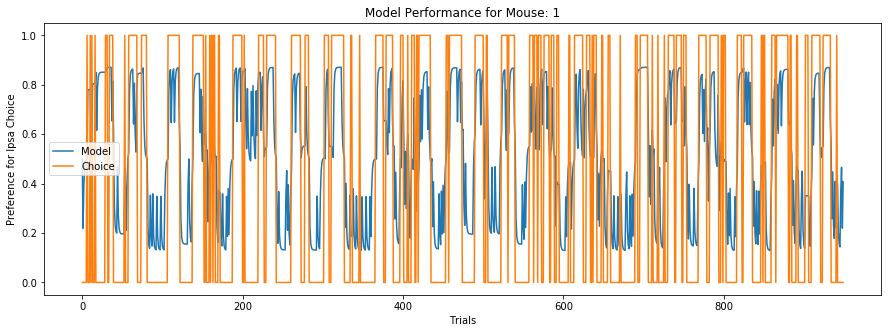

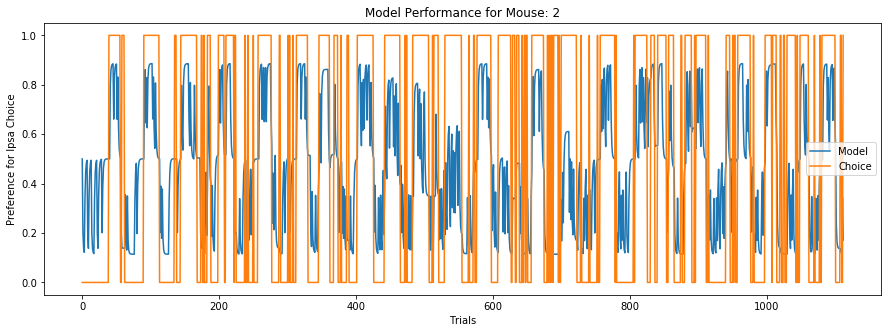

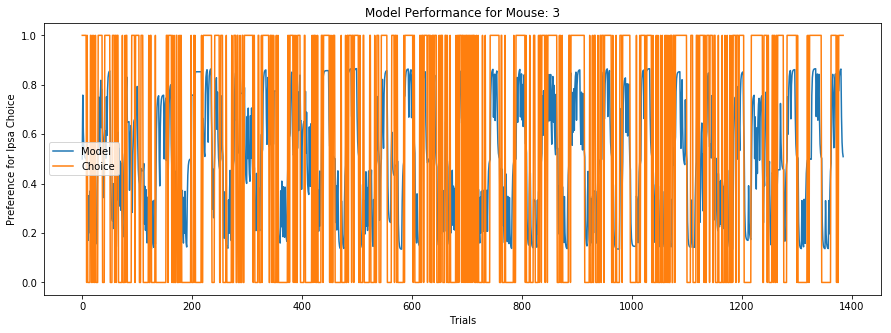

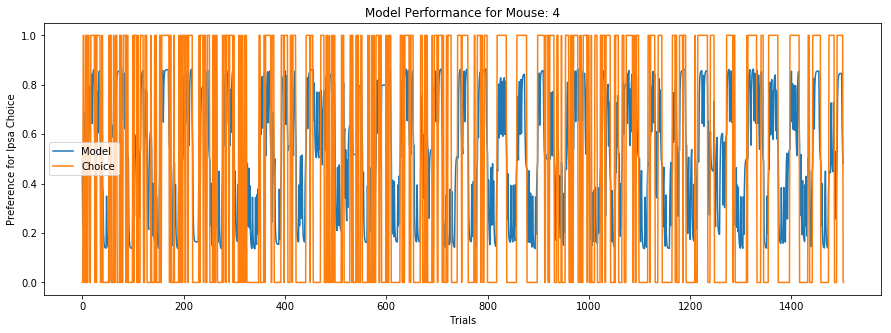

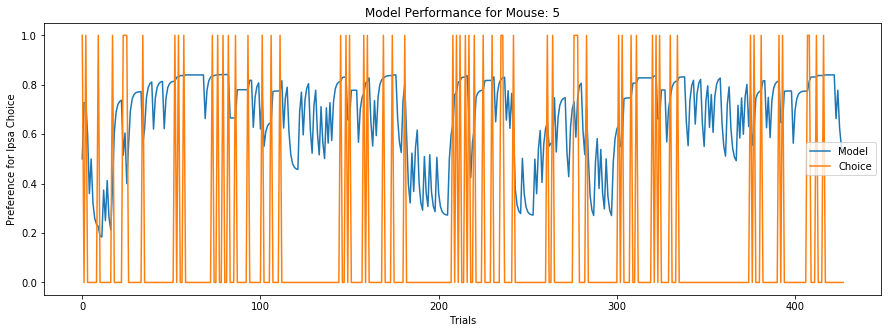

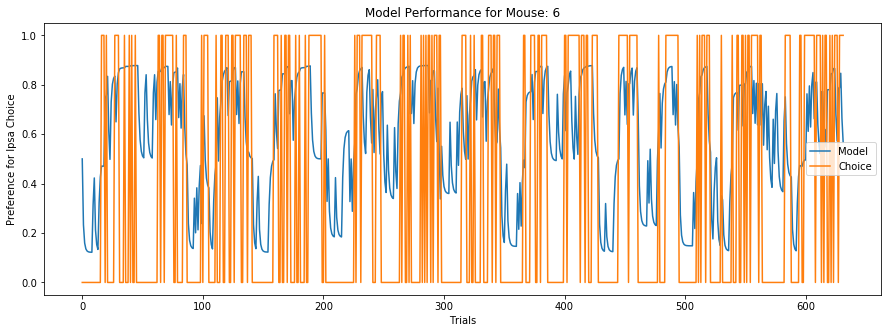

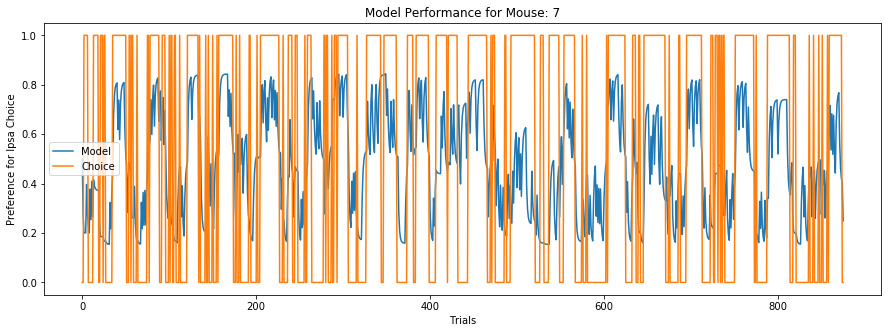

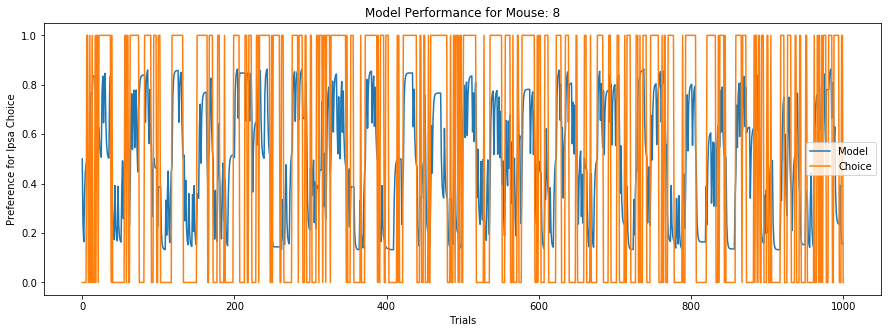

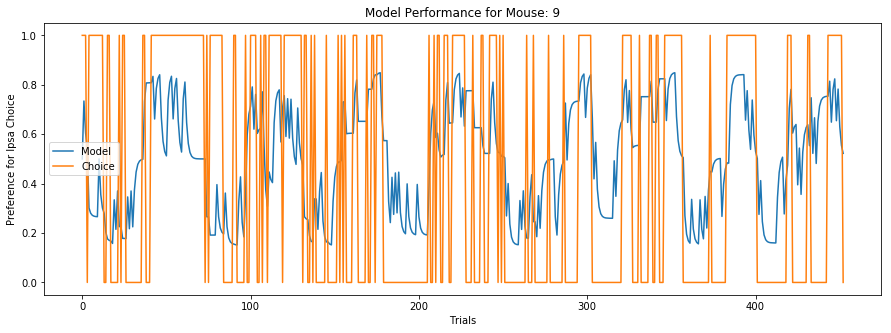

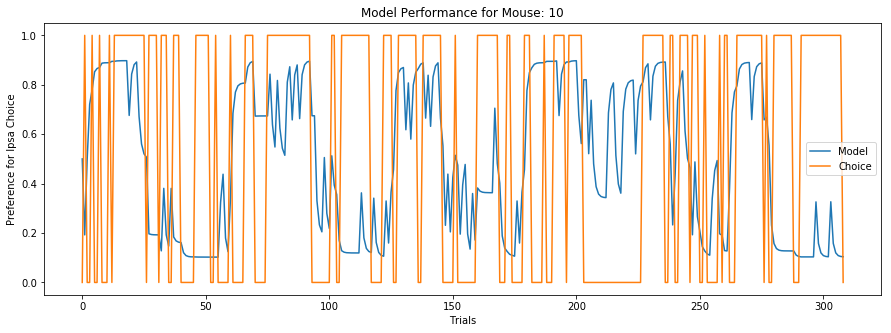

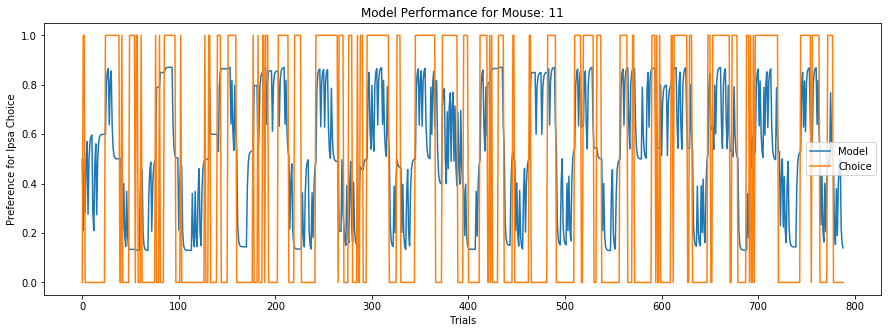

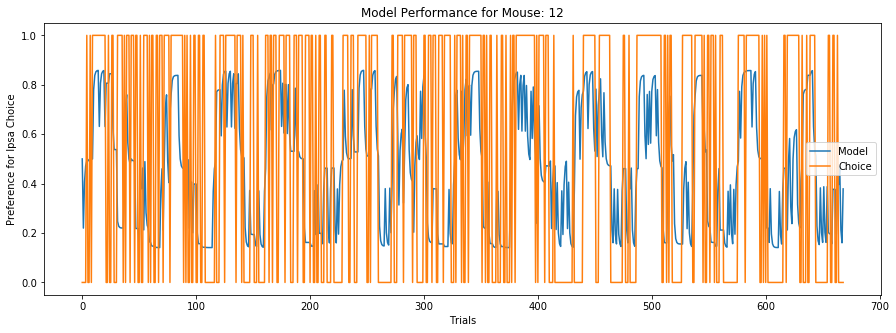

In [50]:
for s in np.arange(NS):

    fig = plt.figure(figsize= (15, 5))
    plt.plot(prob_ipsa[s,:NT_all[s+1]], label = 'Model')
    plt.plot(c[s,:NT_all[s+1]], label = 'Choice')
    plt.legend()
    
    plt.xlabel('Trials')
    plt.ylabel('Preference for Ipsa Choice')
    plt.title('Model Performance for Mouse: {:d}'.format(s + 1))
    

## correlate by time points

In [ ]:
# should I avg according to the number of trials that lasted that long? 

data_tp = []

max_tp = df_trials.groupby('MouseID')['TrialLen'].max()


for mouse_id in np.unique(data['MouseID']):


    data_small = data[data['MouseID'] == mouse_id]
    
    data_tp_i = np.zeros((NT, max_tp[mouse_id]))


    for t in np.arange(NT):
        t_start = df_trials[(df_trials['MouseID'] == mouse_id) & (df_trials['Trial'] == t)].TrialStart.values[0]
        t_end = df_trials[(df_trials['MouseID'] == mouse_id) & (df_trials['Trial'] == t)].TrialEnd.values[0]
        t_len = df_trials[(df_trials['MouseID'] == mouse_id) & (df_trials['Trial'] == t)].TrialLen.values[0]
        
        data_tp_i[t, :t_len] = data_small['gcamp'].values[t_start:t_end]
        
    
    max_tp_actual = np.squeeze(np.nonzero(sum(data_tp_i)))[-1]
    
    data_tp.append(data_tp_i[:, :max_tp_actual])
        





    
    
        

In [ ]:
tp_corr = []; 
for mouse_id in np.unique(data['MouseID']):

    
    data_tp_i = data_tp[mouse_id - 1]

    _, max_tp = np.shape(data_tp_i)
    tp_corr_i = []; 
    for tp in np.arange(max_tp):
        tp_corr_i.append(scipy.stats.pearsonr(Q_i[mouse_id - 1, :-1], data_tp_i[:, tp])[0])
        
    tp_corr.append(tp_corr_i)
        
    

In [ ]:
for s in np.arange(NS):
    tp_corr_i = tp_corr[s]
    
    fig = plt.figure(figsize= (15, 5))
    plt.plot(tp_corr_i)

    
    plt.xlabel('Timepoints')
    plt.ylabel('Correlating Q_ipsa to gcamp values')
    plt.title('Correlation of Q_Ipsa for Mouse: {:d}'.format(s + 1))
    

In [ ]:
tp